# Demo 05 — Vol Surface and No-Arbitrage Diagnostics

This notebook shows a **minimal volatility surface workflow** using `option_pricing`:

- Build a `VolSurface` from a grid of `(T, K, iv)` points
- Query implied vol at off-grid `(K, T)` points
- Run simple **no-arbitrage sanity checks**:
  - per-expiry **call price monotonicity** in strike (proxy check)
  - **calendar** sanity in **total variance** (non-decreasing in expiry)

The goal is to keep the notebook usage-first; details about the surface construction live in the user guide.


## Imports

We import the surface container and the diagnostics helpers.

In [1]:
import numpy as np

from option_pricing.diagnostics.vol_surface.compute import (
    build_surface_from_iv_function,
    calendar_summary,
    noarb_smile_table,
    query_iv_curve,
)
from option_pricing.diagnostics.vol_surface.plot import (
    plot_calendar_heatmap_from_report,
    plot_first_strike_monotonicity_violation,
    plot_queried_smile,
    plot_smile_slices,
)
from option_pricing.models import bs as bs_model
from option_pricing.vol.arbitrage import check_surface_noarb


## Market setup (forward + discount factor)

The surface needs a **forward curve** `F(T)` to convert strikes to log-moneyness:

$$
x = \ln\left(\frac{K}{F(T)}\right)
$$

For this demo we use flat `r` and `q`:

- `F(T) = S * exp((r-q) T)`
- `df(T) = exp(-r T)`


In [2]:
S, r, q = 100.0, 0.02, 0.00

def forward(T: float) -> float:
    return float(S * np.exp((r - q) * float(T)))

def df(T: float) -> float:
    return float(np.exp(-r * float(T)))

expiries = np.array([0.25, 0.50, 1.00, 2.00])
x_grid = np.linspace(-0.4, 0.4, 25)

def iv_good(T: float, x: np.ndarray) -> np.ndarray:
    base  = 0.18 + 0.02 * np.log1p(T / 0.25)
    smile = 0.10 * (x**2)
    skew  = -0.02 * x
    return np.maximum(base + smile + skew, 1e-6)

## Build a synthetic (healthy) surface

We build a surface by specifying implied vols on a log-moneyness grid `x` at several expiries.
Then we convert to strikes via `K = F(T) * exp(x)` and pass `(T, K, iv)` rows to
`VolSurface.from_grid(...)`.

The surface interpolates **linearly in total variance**:

$$
w(T,x) = T \cdot \sigma_{imp}(T,x)^2
$$

- linear interpolation in `x` within each expiry
- linear interpolation in time `T` between expiries


In [3]:
# ---- good surface
surface_good = build_surface_from_iv_function(
    expiries=expiries, x_grid=x_grid, iv_fn=iv_good, forward=forward
)

### Smile slices (IV vs strike)

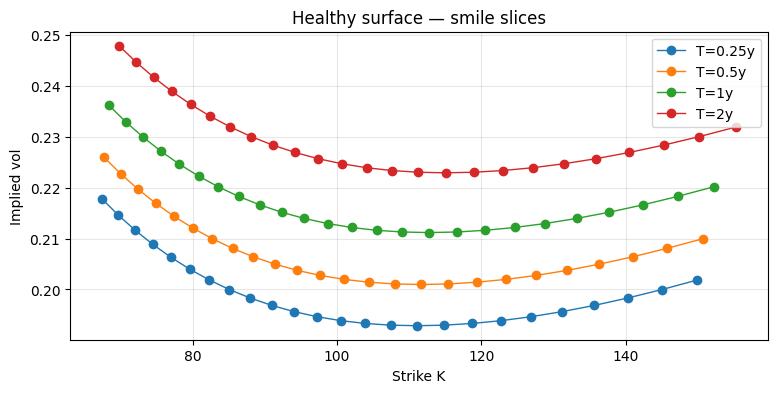

In [4]:

plot_smile_slices(surface_good, forward=forward, title="Healthy surface — smile slices")


### Query the surface at off-grid points

Below we query at an intermediate expiry (`T=0.75`) that is **not** on the input grid.


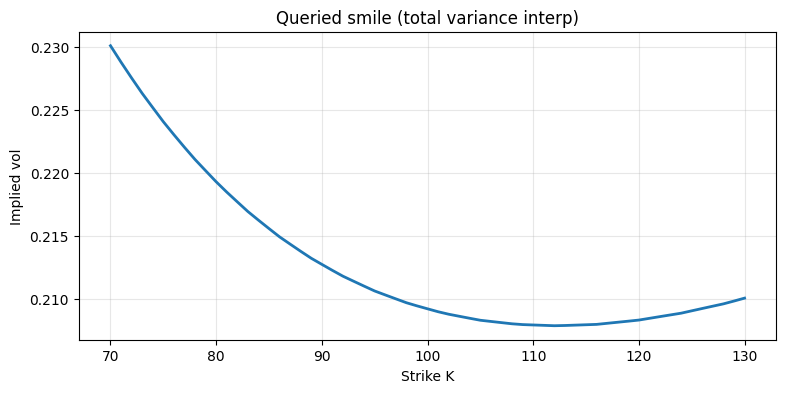

In [5]:

Tq = 0.75
Kq = np.linspace(70.0, 130.0, 61)
iv_q = query_iv_curve(surface_good, K=Kq, T=Tq)
plot_queried_smile(K=Kq, iv=iv_q, T=Tq, title="Queried smile (total variance interp)")


## Run basic no-arbitrage diagnostics

`check_surface_noarb` returns a structured report:

- per-expiry call monotonicity check (call price should be non-increasing in strike)
- calendar check in total variance (at fixed `x`, total variance should not decrease with `T`)


In [6]:

rep_good = check_surface_noarb(surface_good, df=df)
print(rep_good.message)
display(noarb_smile_table(rep_good))

OK, smiles_bad=0/4, calendar=OK


,T,ok,max_violation,n_bad_intervals,message
0,0.25,True,0.0,0,OK
1,0.50,True,0.0,0,OK
2,1.00,True,0.0,0,OK
3,2.00,True,0.0,0,OK


In [7]:

cal_dict = calendar_summary(rep_good)
print("Calendar performed:", cal_dict["performed"])
print("Calendar OK:", cal_dict["ok"])
print("Calendar message:", cal_dict["message"])

Calendar performed: True
Calendar OK: True
Calendar message: OK


## A deliberately broken surface (to see the flags)

We now create a surface that violates:

1) **Strike monotonicity** at one expiry by making vol increase very steeply with strike  
2) **Calendar total variance** by making long-dated vols unrealistically low


In [8]:
def iv_bad_smile(T: float, x: np.ndarray) -> np.ndarray:
    return 0.12 + 0.90 * (x - x.min())

def iv_bad_term_structure(T: float, x: np.ndarray) -> np.ndarray:
    return 0.10 + 0.02 * (x**2)

def iv_bad(T: float, x: np.ndarray) -> np.ndarray:
    if np.isclose(T, 1.0): 
        return iv_bad_smile(T, x)
    if np.isclose(T, 2.0): 
        return iv_bad_term_structure(T, x)
    return iv_good(T, x)

surface_bad = build_surface_from_iv_function(
    expiries=expiries, x_grid=x_grid, iv_fn=iv_bad, forward=forward
)

rep_bad = check_surface_noarb(surface_bad, df=df)
print(rep_bad.message)
display(noarb_smile_table(rep_bad))

Violations found, smiles_bad=1/4, calendar=BAD


,T,ok,max_violation,n_bad_intervals,message
0,0.25,True,0.000000,0,OK
1,0.50,True,0.000000,0,OK
2,1.00,False,0.264933,9,Call monotonicity violated at 9 intervals.
3,2.00,True,0.000000,0,OK


### Smile slices for the broken surface

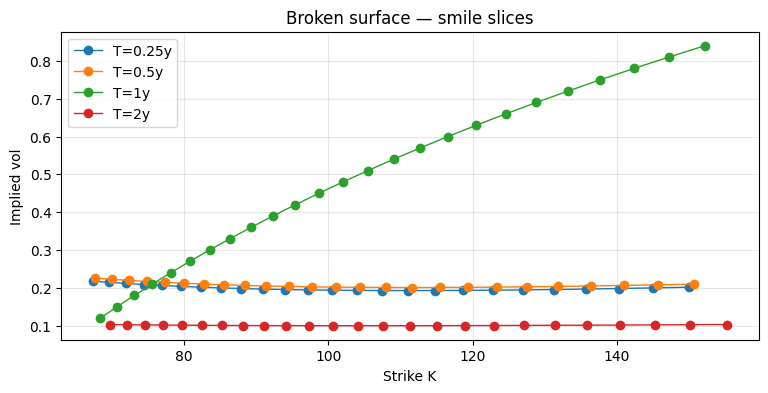

In [9]:
plot_smile_slices(surface_bad, forward=forward, title="Broken surface — smile slices")


### Visualize a monotonicity violation (call price vs strike)

For the first failing expiry, we plot call prices on the surface's internal strike grid and
highlight the intervals that violate monotonicity.


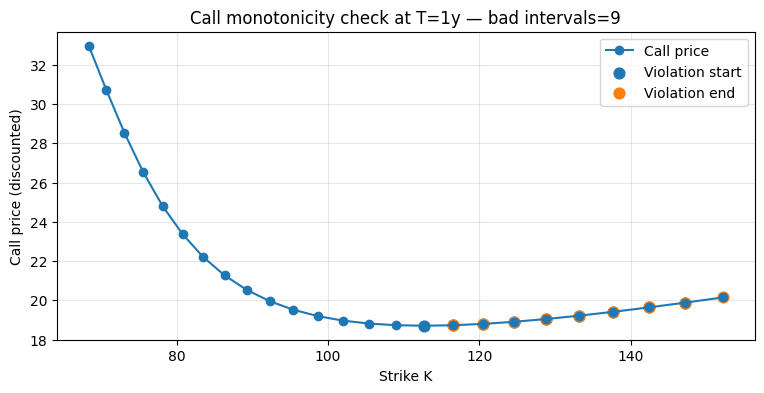

In [10]:
plot_first_strike_monotonicity_violation(surface_bad, rep_bad, forward=forward, df=df, bs_model=bs_model)

### Visualize calendar total-variance violations

The calendar check works in **total variance** `w = T * iv^2` on a common `x` grid.
If `w` decreases with expiry at fixed `x`, that usually signals an inconsistent term structure.


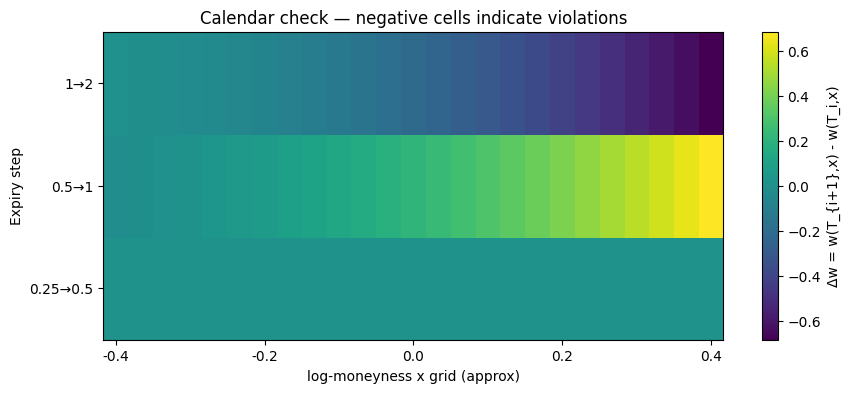

In [11]:

plot_calendar_heatmap_from_report(surface_bad, rep_bad)


## Takeaways

- `VolSurface.from_grid` gives you a minimal **desk-like** surface object:
  build → query → plot.
- The no-arb checks here are **sanity checks** (not a full arbitrage-free surface fitter),
  but they catch common issues in synthetic or noisy data.
- If you see violations, your next steps are usually:
  - clean input data,
  - choose a smoother / more appropriate parameterization (SVI/SABR),
  - or enforce constraints during calibration.
